# 6) Supervised Euclidean
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json

import tensorflow as tf
import numpy as np
import segmentation_models as sm
import tensorflow.keras.backend as kb

from unet import UNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.model_selection import train_test_split
from segmentation_models.losses import dice_loss
from segmentation_models.metrics import iou_score
from lastengen import LASTENSequence
from matplotlib import pyplot as plt

Segmentation Models: using `tf.keras` framework.


# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data
Import training images

In [4]:
path = r'/home/julian/Documents/Studium/MT-Masterarbeit/Data/SIMPLE'

width = 112
height = 112

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=16, layers=4, activation='linear', classes=2, input_shape=(112, 112, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 112, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 16) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Data Preparation
The generator sequence for training is built.

In [7]:
fixed = imageio.imread(path + "/fixed.png")
moving = imageio.imread(path + "/moving.png")

fixed = fixed[:,:,0]
moving = moving[:,:,0]

X = np.zeros((width, height, 2))

X[:,:,0] = moving
X[:,:,1] = fixed

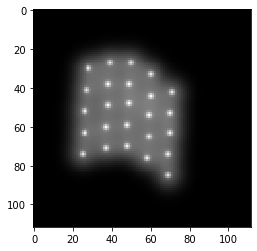

In [8]:
plt.imshow(X[:,:,0], cmap="gray")

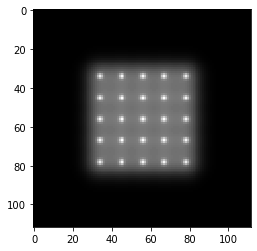

In [9]:
plt.imshow(X[:,:,1], cmap="gray")

In [10]:
moving_json_file = open(path  + '/moving.json')
fixed_json_file = open(path + '/fixed.json')

moving_data = json.load(moving_json_file)
fixed_data = json.load(fixed_json_file)

moving_json_file.close()
fixed_json_file.close()

labels = np.zeros((25,2,2))


for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]

    labels[index][0][0] = x
    labels[index][1][0] = y
    
for index in range(0,25):
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]

    labels[index][0][1] = x
    labels[index][1][1] = y  

# Training Preparation
Prepare the settings for training the model.

In [11]:
X_train = np.array([X])
y_train = np.array([labels])

In [50]:
y_train = y_train.astype(int)

In [94]:
def custom_loss(labels, prediction):
    #prediction.shape # batch_sizex112x112x2 (x, y, ux-uy)
    #labels.shape # batch_sizex25x2x2 (coord, x-y, mov-fix)
    
    ux = prediction[0,:,:,0]
    
    
    x_labels = labels[0,:,0,0]
    
    x_cast = kb.cast(x_labels, "int32")
    
    result = kb.gather(ux, x_cast)
    
    print(result.shape)
    
    return 0

In [95]:
logger = CSVLogger("experiments/segmentation.log")
checker = ModelCheckpoint("experiments/segmentation/weights.{epoch:02d}.hdf5",
                          period=50)

callbacks = [logger, checker]

model.compile(optimizer='adam',
              loss = custom_loss)

In [96]:
model.fit(X_train, y_train, batch_size=1, epochs=100)

Epoch 1/100
(25, 112)


ValueError: in user code:

    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:540 train_step  **
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1806 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:521 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1218 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['conv2d/kernel:0', 'batch_normalization/gamma:0', 'batch_normalization/beta:0', 'conv2d_1/kernel:0', 'batch_normalization_1/gamma:0', 'batch_normalization_1/beta:0', 'conv2d_2/kernel:0', 'batch_normalization_2/gamma:0', 'batch_normalization_2/beta:0', 'conv2d_3/kernel:0', 'batch_normalization_3/gamma:0', 'batch_normalization_3/beta:0', 'conv2d_4/kernel:0', 'batch_normalization_4/gamma:0', 'batch_normalization_4/beta:0', 'conv2d_5/kernel:0', 'batch_normalization_5/gamma:0', 'batch_normalization_5/beta:0', 'conv2d_6/kernel:0', 'batch_normalization_6/gamma:0', 'batch_normalization_6/beta:0', 'conv2d_7/kernel:0', 'batch_normalization_7/gamma:0', 'batch_normalization_7/beta:0', 'conv2d_8/kernel:0', 'batch_normalization_8/gamma:0', 'batch_normalization_8/beta:0', 'conv2d_9/kernel:0', 'batch_normalization_9/gamma:0', 'batch_normalization_9/beta:0', 'conv2d_10/kernel:0', 'batch_normalization_10/gamma:0', 'batch_normalization_10/beta:0', 'conv2d_11/kernel:0', 'batch_normalization_11/gamma:0', 'batch_normalization_11/beta:0', 'conv2d_12/kernel:0', 'batch_normalization_12/gamma:0', 'batch_normalization_12/beta:0', 'conv2d_13/kernel:0', 'batch_normalization_13/gamma:0', 'batch_normalization_13/beta:0', 'conv2d_14/kernel:0', 'batch_normalization_14/gamma:0', 'batch_normalization_14/beta:0', 'conv2d_15/kernel:0', 'batch_normalization_15/gamma:0', 'batch_normalization_15/beta:0', 'conv2d_16/kernel:0', 'batch_normalization_16/gamma:0', 'batch_normalization_16/beta:0', 'conv2d_17/kernel:0', 'batch_normalization_17/gamma:0', 'batch_normalization_17/beta:0', 'segmentation/kernel:0'].


In [9]:
X, y = train_gen[0]
y_pred = model.predict(X)

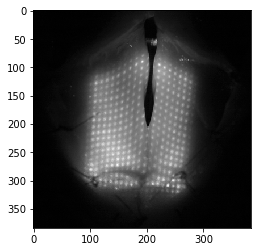

In [10]:
plt.imshow(X[0,:,:,0], cmap="gray")

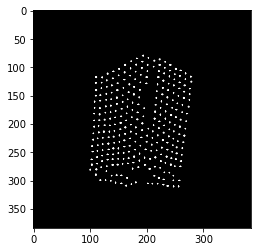

In [11]:
plt.imshow(y[0,:,:,0], cmap="gray")

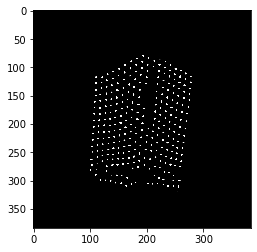

In [12]:
plt.imshow(y_pred[0,:,:,0], cmap="gray")

In [13]:
plt.imsave("y.png",y[0,:,:,0], cmap="gray")

In [14]:
plt.imsave("y_pred.png",y_pred[0,:,:,0], cmap="gray")